(48, 1)


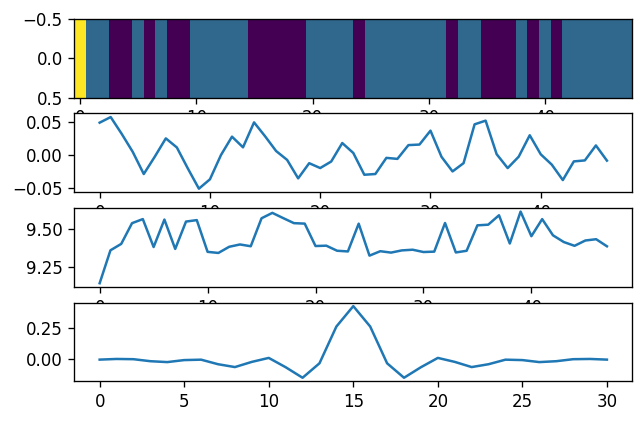

In [2]:
from importlib import reload 
import numpy as np
import h5py
from utils import *
import time

## Prior parameter ##
nl_level = 10

PRIOR = np.ones(4, dtype=[('MU', float, (4)), ('C', float, (4,4))])

mu = np.ones([4,4])
mu[0] = [8.5948, 8.0356, 0.9613, 9.5561]
mu[1] = [8.4563, 7.8829, 0.9186, 9.3749]
mu[2] = [8.6676, 8.0483, 1.0716, 9.7392]
mu[3] = [8.4136, 7.8345, 0.7348, 9.1484]
#print(mu)

c = np.ones([4,4,4])
c[0,:] = [[0.0037, 0.0027, 0.0008, 0.0000],
            [0.0027, 0.0030, 0.0008, 0.0000],
            [0.0008, 0.0008, 0.0003, 0.0000],
            [0.0000, 0.0000, 0.0000, 0.0111]]

c[1,:] = [[0.0032, 0.0028, 0.0011, 0.0000],
            [0.0028, 0.0033, 0.0010, 0.0000],
            [0.0011, 0.0010, 0.0006, 0.0000],
            [0.0000, 0.0000, 0.0000, 0.0096]]

c[2,:] = [[0.0023, 0.0016, 0.0008, 0.0000],
            [0.0016, 0.0017, 0.0007, 0.0000],
            [0.0008, 0.0007, 0.0006, 0.0000],
            [0.0000, 0.0000, 0.0000, 0.0070]]

c[3,:] = [[0.0008, 0.0005, 0.0003, 0.0000],
            [0.0005, 0.0004, 0.0002, 0.0000],
            [0.0003, 0.0002, 0.0003, 0.0000],
            [0.0000, 0.0000, 0.0000, 0.0023]]
#print(c)

wavelet_new = [-1039.55055580727,
            -4026.57620068033,
            -8194.18572794536,
            -11356.0387947636,
            -11906.6435543803,
            -10191.4389229172,
            -8639.29324618705,
            -10474.3682826362,
            -17093.5087710456,
            -25733.4288332681,
            -29906.2345220425,
            -23088.0727988944,
            -3091.80943987738,
            25306.1208726887,
            51180.4184438887,
            63288.5822013372,
            53619.9099732780,
            32940.2018555759,
            11743.5370194762,
            -3175.56289063239,
            -10845.0261972202,
            -13246.6910319655,
            -12569.5536619989,
            -10329.2514738468,
            -7512.57465309683,
            -5018.31852539635,
            -3551.82629919458,
            -3000.47980521376,
            -2436.41725067266,
            -1305.36051838710,
            -346.558408174331]

PRIOR['MU'] = mu
PRIOR['C'] = c

## Geracao do ensemble ##
n = 48
I = n
J = 1
signal2noise = 5
v_fact = 0.1

wavelet = np.array(wavelet_new)

delta = np.zeros([31,1])
delta[np.around(delta.shape[0]/2).astype(int)-1,0] = 1

wavelet = lowPassFilter2(delta,4,40,60) - lowPassFilter2(delta,4,40,6)

G = acoustic_foward_matrix(wavelet,I)

#P = np.matrix('0.7 0.3 0 0; 0.3 0.7 0 0; 0.33 0.33 0.34 0; 0.1 0.1 0.1 0.7')
P = np.matrix('0.7 0.3 0 0; 0.3 0.7 0 0; 0.33 0.33 0.34 0; 0.1 0.1 0.1 0.7')
P = np.array(P)

facies = simulate_markov_chain(P,n,3,1)
print(facies.shape)
mu, log_imp, seismic = facies_forward_model(facies, PRIOR, G, v_fact)

noise = np.random.randn(I-1,1)
noise = noise/np.std(noise)
std_noise = np.std(seismic)/np.sqrt(signal2noise)
noise = noise*std_noise
seismic = seismic + noise.ravel()

fig, axs = plt.subplots(4)
fig.set_dpi(120)
axs[0].imshow(facies.transpose(), aspect='auto')
axs[1].plot(seismic)
axs[2].plot(log_imp)
axs[3].plot(wavelet)
plt.show()

# Gera modelo

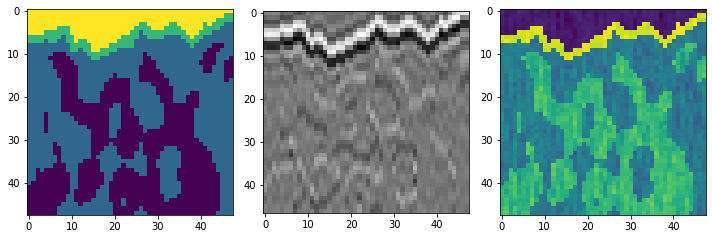

In [3]:
from scipy.ndimage.filters import gaussian_filter

Pver = np.array(np.matrix('0.7 0.3 0 0; 0.3 0.7 0 0; 0.33 0.33 0.34 0; 0.066 0.066 0.066 0.802'))
Phor = np.array(np.matrix('0.4 0.4 0.1 0.1; 0.4 0.4 0.1 0.1; 0.1 0.1 0.6 0.2; 0.1 0.1 0.2 0.6'))

#Simulation grid size

I = 48
J = 48
initial_facies = 3

prior_map = np.ones([I, J, 4])

simulation = simulate_markov_2Dchain(Phor, Pver, prior_map, initial_facies)
ss = gaussian_filter(simulation, sigma=[2, 1])
st = simulation == 3
ss[st] = 3
ss = np.round(gaussian_filter(ss, sigma=[1.2, 1]))

def facies_forward_model_2D(facies, PRIOR, G, v_fact):
  seismics = []
  impedances = []
  for j in range(0,J):
    mu, log_imp, seismic = facies_forward_model(facies[:,j], PRIOR, G, v_fact)
    seismics.append(seismic)
    impedances.append(log_imp)

  seismics = np.array(seismics).transpose()
  impedances = np.array(impedances).transpose()
  return seismics, impedances

seis, immp = facies_forward_model_2D(ss, PRIOR, G, v_fact)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
axes[0].imshow(ss)
axes[1].imshow(seis, cmap='gray')
axes[2].imshow(immp)
fig.tight_layout()

# Carrega o dataset em H5

In [4]:
import numpy as np
import h5py
hf = h5py.File('data_set_2D.h5', 'r')
X_bk = np.array(hf['X'])
hf.close()
print(X_bk.shape)

(4000, 48, 48)


# Normaliza o modelo

In [5]:
X = np.copy(X_bk).astype(dtype='float32')
X /= X.max()
#X = (X - 0.5) / 0.5 # normalize (-1,1)
X = np.expand_dims(X, axis=3)
#X = np.transpose(X, axes=(0,2,1,3))
#X = tf.keras.utils.to_categorical(X)
print(X.shape)
print(X_bk.min(),X_bk.max())
print(X.min(),X.max())

(4000, 48, 48, 1)
0.0 3.0
0.0 1.0


# Treinamento

In [ ]:
from IPython.display import clear_output
import tensorflow as tf
import random

class SampleImgs(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        rnd = random.randint(0, X.shape[0]-1)
        rnd_img = tf.expand_dims(X[rnd], axis=0)
        z_mean, z_log_var, z = vae.encoder(rnd_img)
        fig,axs = plt.subplots(1,3)
        axs[0].imshow((rnd_img)[0])
        axs[1].imshow(np.around(vae.decoder(z)[0]*3))
        axs[2].hist(z.numpy().flatten())
        plt.show()

class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        #print(z_mean.shape)
        batch = tf.shape(z_mean)[0]
        dim1 = tf.shape(z_mean)[1]
        dim2 = tf.shape(z_mean)[2]
        ch = tf.shape(z_mean)[3]
        sh = (batch, dim1, dim2, ch)
        #print(sh)
        epsilon =  tf.random.normal(shape=sh)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(tf.keras.Model):
    def __init__(self, **kwargs):
        super(VAE, self).__init__(**kwargs)

        self.img_rows = 48
        self.img_cols = 48
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 12
        self.latent_dim_shape = (self.latent_dim, self.latent_dim, self.channels)

        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
    
    def build_encoder(self):

        encoder_inputs = tf.keras.Input(shape=self.img_shape)
        x = tf.keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
        x = tf.keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
        x = tf.keras.layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
        #x = tf.keras.layers.Flatten()(x)
        #x = tf.keras.layers.Dense(16, activation="relu")(x)
        z_mean = tf.keras.layers.Conv2D(1, 1, strides=1, padding='same', name="z_mean")(x)
        z_log_var = tf.keras.layers.Conv2D(1, 1, strides=1, padding='same', name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
        encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
        encoder.summary()

        return encoder

    def build_decoder(self):

        latent_inputs = tf.keras.Input(shape=self.latent_dim_shape)
        #x = tf.keras.layers.Dense(6 * 6 * 64, activation="relu")(latent_inputs)
        #x = tf.keras.layers.Reshape((6, 6, 64))(x)
        x = tf.keras.layers.Conv2D(32, 1, activation="relu", strides=1, padding="same")(latent_inputs)
        x = tf.keras.layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
        x = tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
        x = tf.keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
        decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
        decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
        decoder.summary()

        return decoder

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        clear_output(wait=False)
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

vae = VAE()
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(X, epochs=30, batch_size=32, callbacks=[SampleImgs()])

In [ ]:
vae.fit(X, epochs=30, batch_size=32, callbacks=[SampleImgs()])

# Imprime amostragens

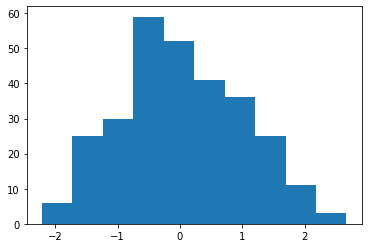

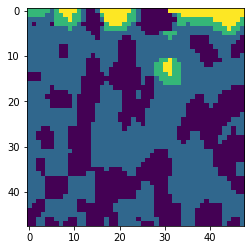

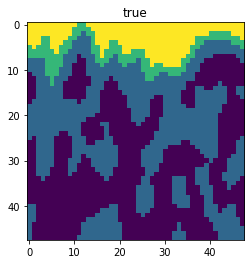

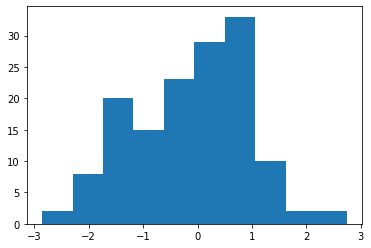

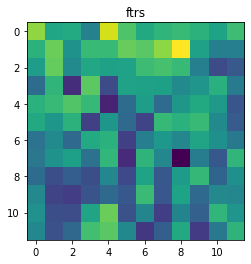

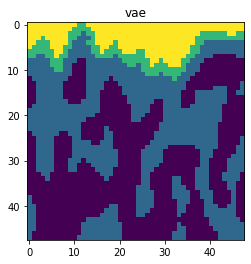

In [26]:
rn = tf.random.normal(shape=[2, vae.latent_dim, vae.latent_dim, 1], mean=0, stddev=1)
#rn = tf.random.normal(shape=[2, cvae.latent_dim])

plt.hist(rn.numpy().flatten())
plt.show()

plt.imshow(np.around(vae.decoder.predict(rn)*3)[0])
plt.show()

plt.imshow(np.around(X[50]*3))
plt.title('true')
plt.show()

ftrs = vae.encoder.predict(X[50:51])
plt.hist(ftrs[0].flatten())
plt.show()

teste = ftrs[0].reshape((12, 12 ))
plt.imshow(teste)
plt.title('ftrs')
plt.show()

plt.imshow(np.around(vae.decoder.predict(ftrs[-1])*3)[0])
plt.title('vae')
plt.show()

# função

In [28]:
def plt_ensamble(modelo_samples):
    #w, h = int(math.sqrt(n_samples)), int(math.sqrt(n_samples))    
    w = 1
    h = 4
    

    fig, axs = plt.subplots(1,4, figsize=(8, 2), dpi=150)
    plt.xticks(fontsize=6)
    #gan_facies = tf.experimental.numpy.around(cvae.sample(eps=modelo_samples)*3)
    idx = 0
    for i in range(0,1):
        for j in range(0,4):
            axs[j].hist(tf.reshape(modelo_samples[idx], [modelo_samples.shape[1], modelo_samples.shape[2]]).numpy().flatten())
            idx = idx + 1
    #fig.tight_layout()
    for axr in axs:
        axr.xaxis.set_tick_params(labelsize=6)
        axr.yaxis.set_tick_params(labelsize=6)
    plt.show()
    
    fig, axs = plt.subplots(w,h, figsize=(8, 2), dpi=150)
    #gan_facies = tf.experimental.numpy.around(cvae.sample(eps=modelo_samples)*3)
    gan_facies = np.around(vae.decoder.predict(modelo_samples)*3)
    idx = 0
    for i in range(0,w):
        for j in range(0,h):
            axs[j].imshow(tf.reshape(gan_facies[idx], [n,n]))
            axs[j].axis('off')
            #axs[i,j].set_xticklabels([])
            #axs[i,j].set_yticklabels([])
            #axs[i,j].set_aspect('equal')
            idx = idx + 1
    #fig.tight_layout()
    plt.show()
    
def plt_ensamble_dense(modelo_samples):
    w, h = int(math.sqrt(n_samples)), int(math.sqrt(n_samples))    
    fig, axs = plt.subplots(w,h, figsize=(15, 15), dpi=150)
    gan_facies = tf.experimental.numpy.around(cvae_dense.sample(eps=modelo_samples[idx])*3)
    idx = 0
    for i in range(0,w):
        for j in range(0,h):
            axs[i,j].imshow(tf.reshape(gan_facies[idx], [n,n]))
            axs[i,j].axis('off')
            #axs[i,j].set_xticklabels([])
            #axs[i,j].set_yticklabels([])
            #axs[i,j].set_aspect('equal')
            idx = idx + 1
    #fig.tight_layout()
    plt.show()
#plt_ensamble(modelo_samples)

# Inflaction factor

In [ ]:
alpha = np.ones([10])
c = np.sum(1/alpha)
alpha = c*alpha
alpha

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])

# ESMDA

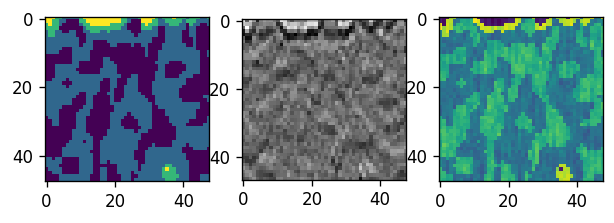

alpha
tf.Tensor(5.0, shape=(), dtype=float32)
Initial ensemble...


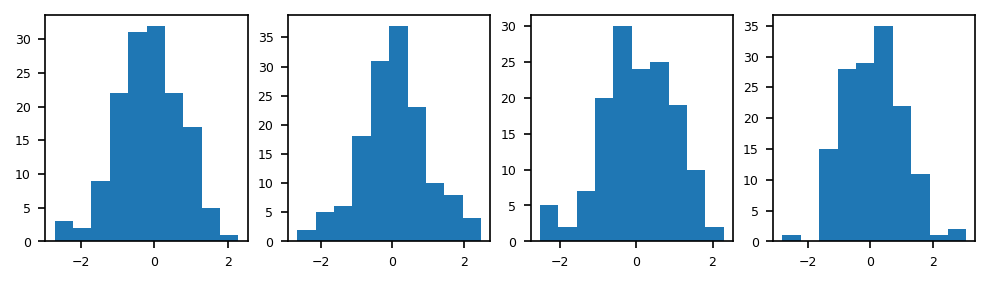

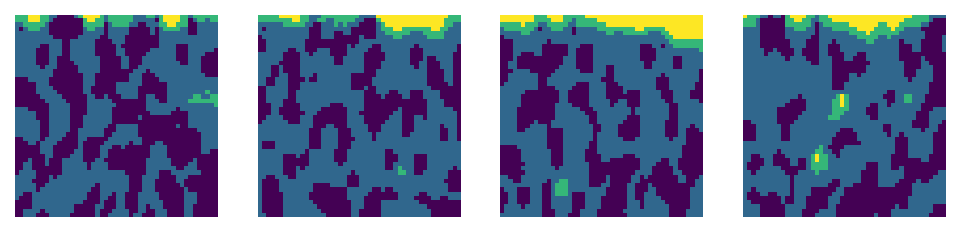

Update  1


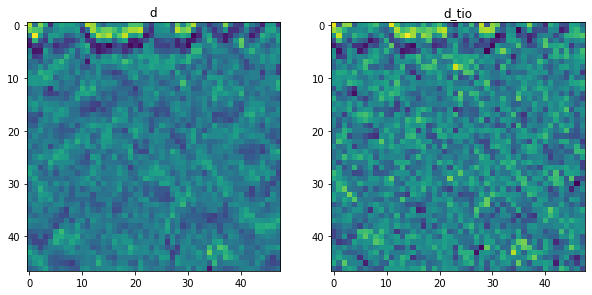

(2256, 2256) (144, 2256)


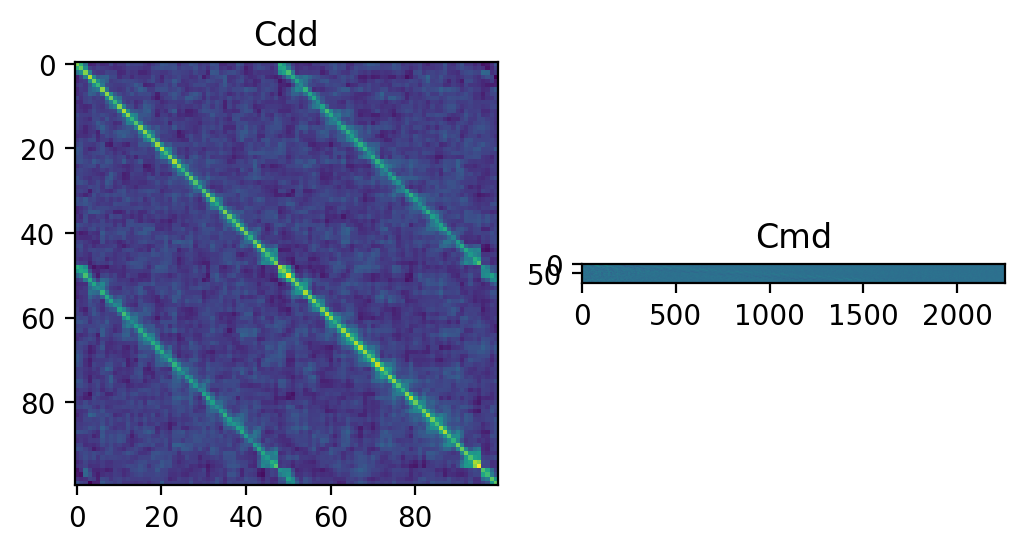

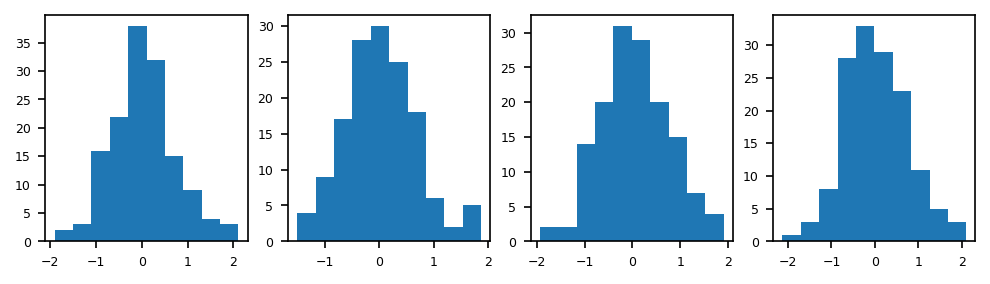

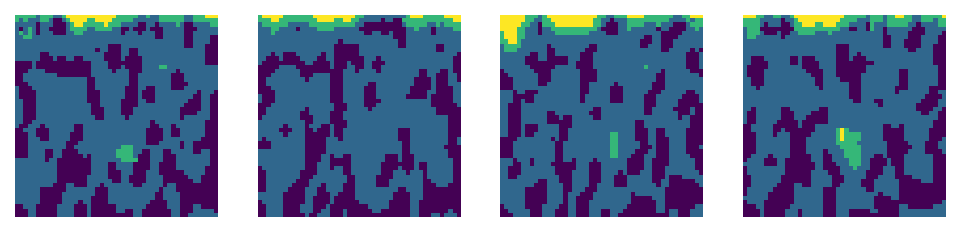

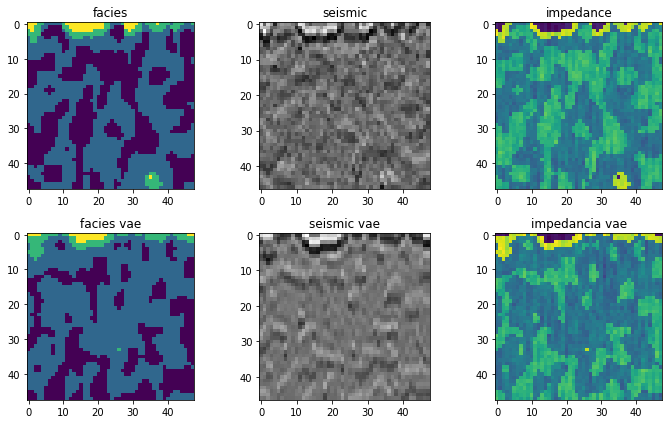

Update  2


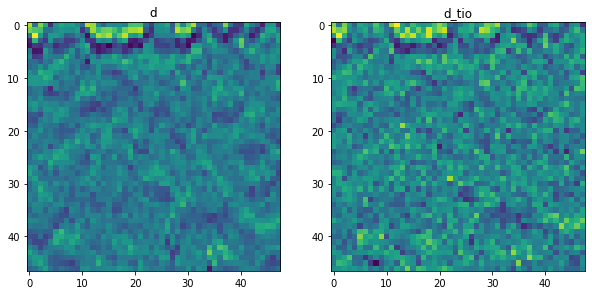

(2256, 2256) (144, 2256)


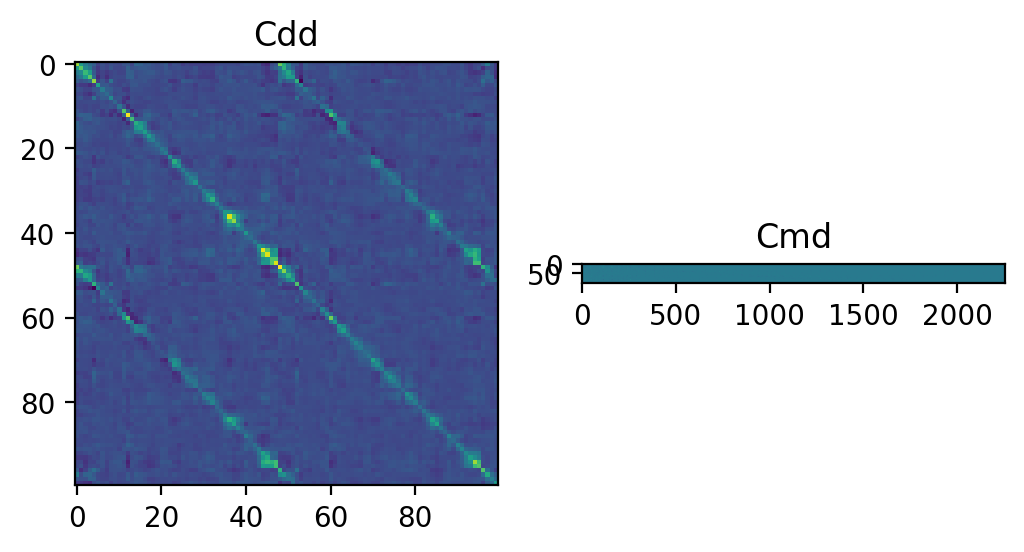

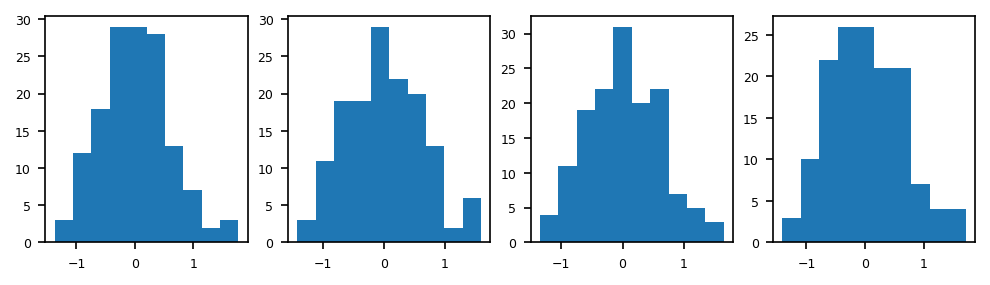

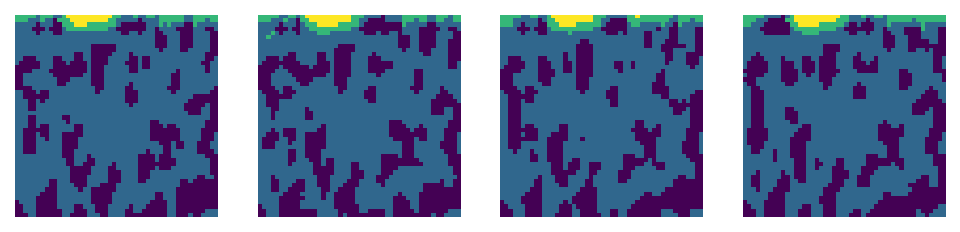

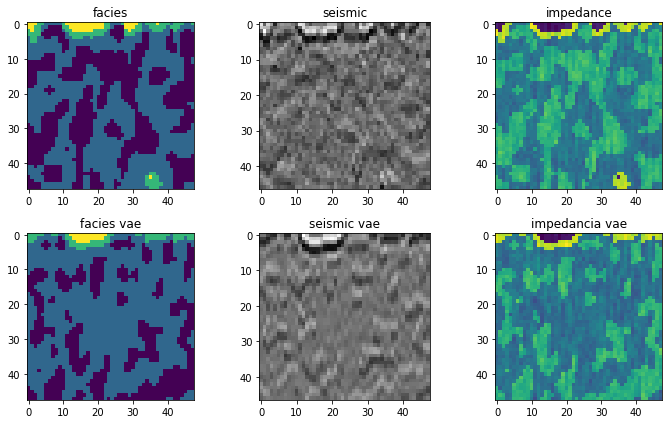

Update  3


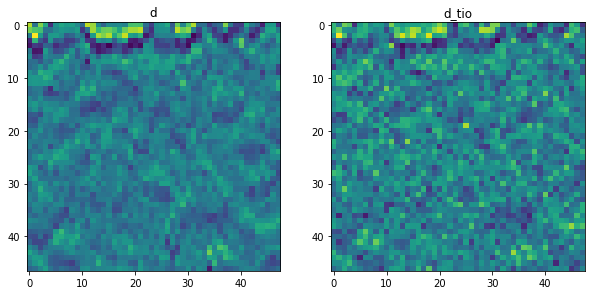

(2256, 2256) (144, 2256)


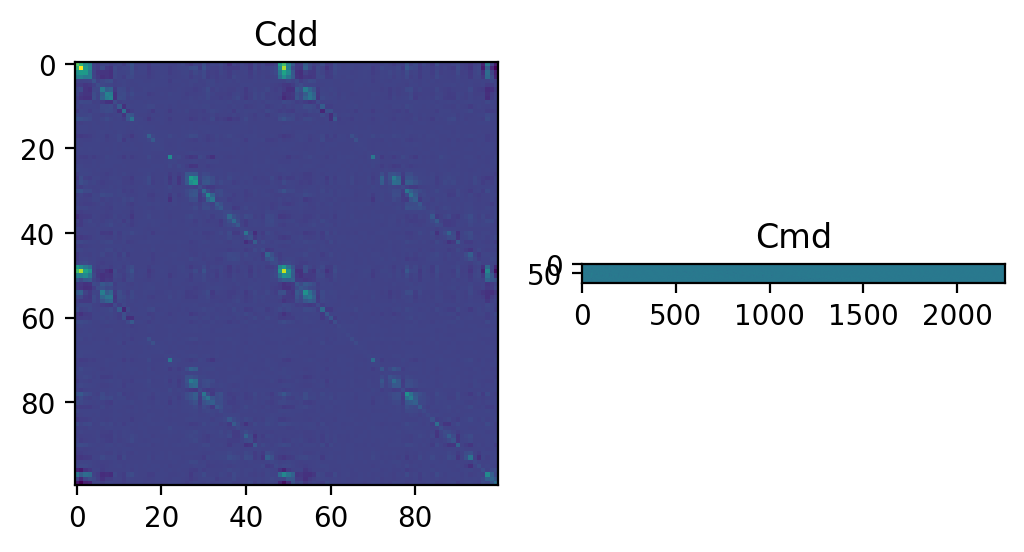

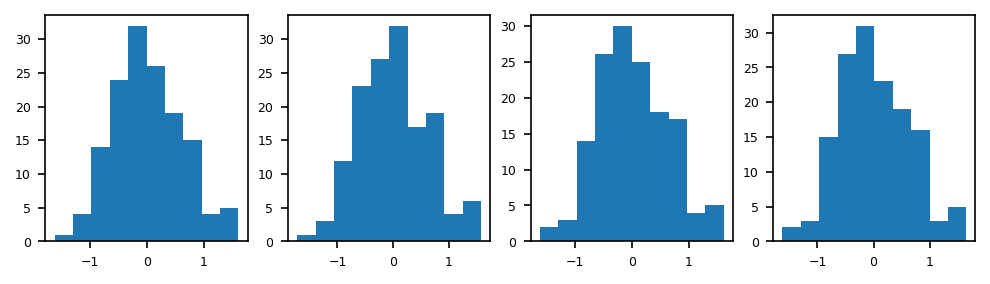

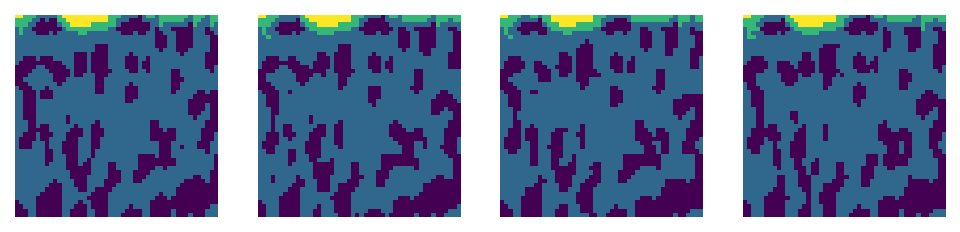

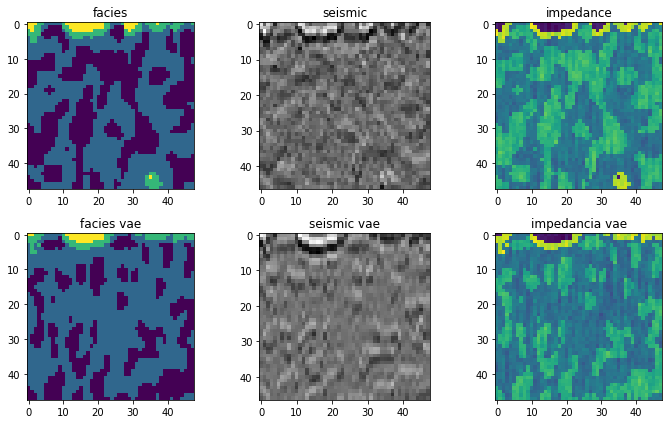

Update  4


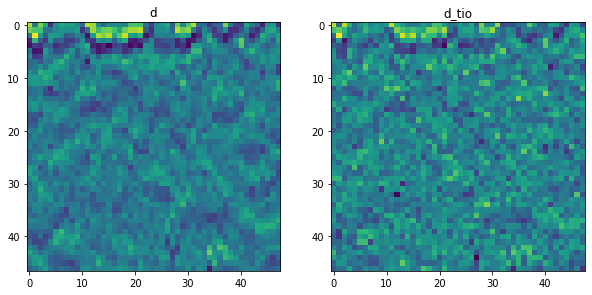

(2256, 2256) (144, 2256)


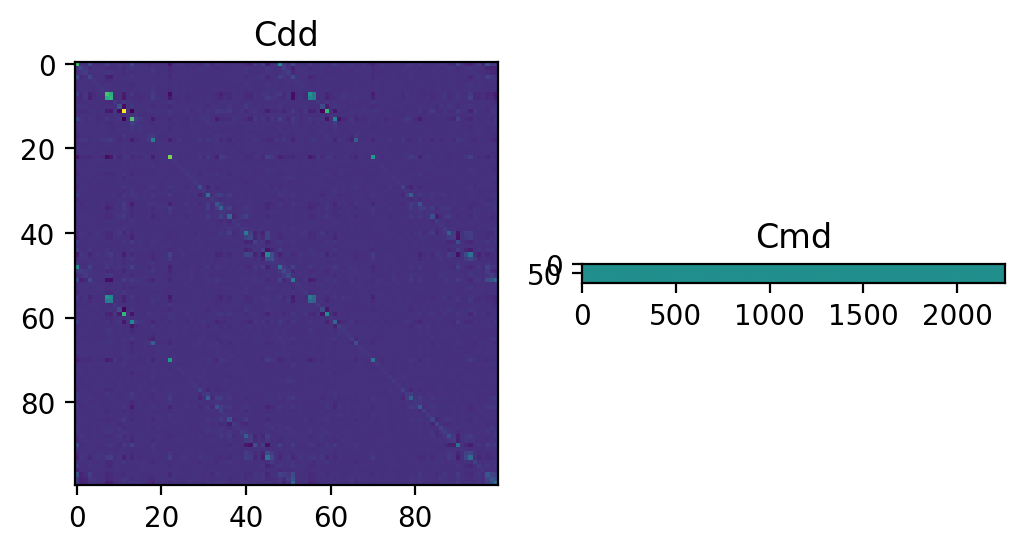

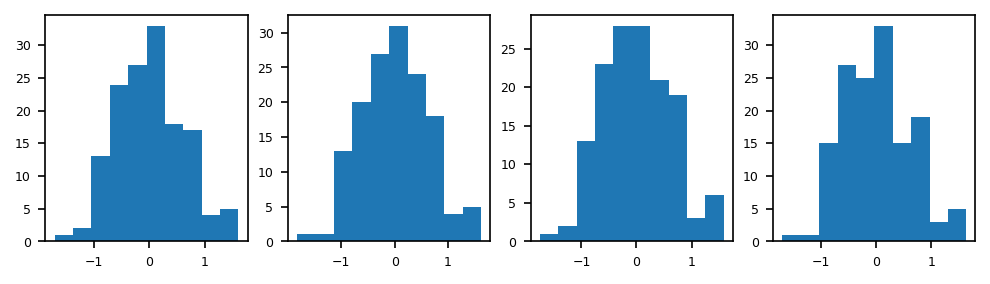

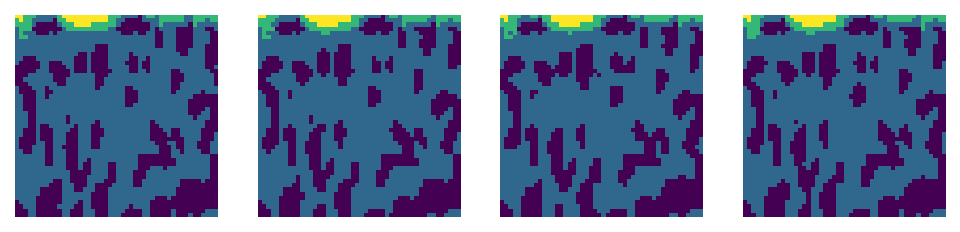

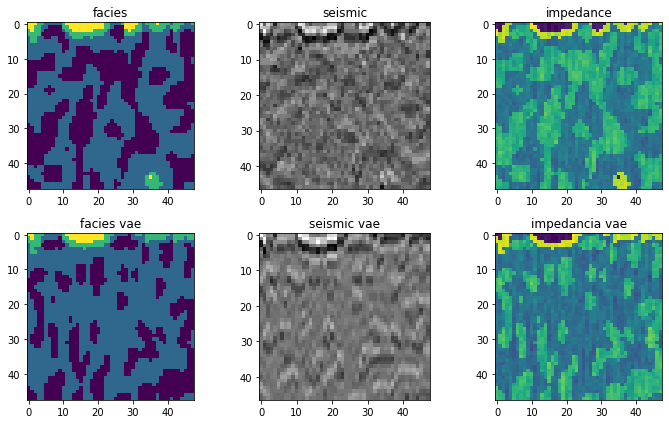

Total time(s):  109.12831401824951


In [81]:
from IPython.core.debugger import set_trace

import time

updts = 5
ensize = 200
cut_factor = 1

G = tf.constant(acoustic_foward_matrix(wavelet,I), np.float32)

ms = tf.Variable(tf.random.normal(shape=[ensize, vae.latent_dim * vae.latent_dim])*cut_factor)
seis = tf.Variable(tf.zeros([ensize, G.shape[0]*G.shape[1]]))
imps =  tf.Variable(tf.zeros([ensize, (G.shape[0]+1) * G.shape[1]]))

### 
rn = tf.random.normal(shape=[2, vae.latent_dim, vae.latent_dim, 1], mean=0, stddev=1)
facies = np.around( vae.decoder.predict(rn)*3)[0]

mr = tf.constant(facies.reshape(1,n,n,1), dtype=tf.float32)
#mr_l = tf.constant(vae.encoder.predict(mr/3)[0])
seis_exp_tmp, imp_exp_tmp = facies_forward_model_2D(mr.numpy().reshape(n,n),PRIOR,G.numpy(), v_fact)
seis_exp = tf.constant(seis_exp_tmp.reshape(-1), dtype=tf.float32)
imp_exp = tf.constant(imp_exp_tmp.reshape(-1), dtype=tf.float32)

noise = np.random.randn((I-1)*J)
noise = noise/np.std(noise)
std_noise = np.std(seis_exp)/np.sqrt(signal2noise)
noise = noise*std_noise
#seis_exp = seis_exp + noise

fig, axs = plt.subplots(1,3)
fig.set_dpi(120)
axs[0].imshow(mr.numpy().reshape(n,n))
axs[1].imshow(seis_exp.numpy().reshape(n-1,n), cmap='gray')
axs[2].imshow(imp_exp.numpy().reshape(n,n))
plt.margins(0,0)
plt.show()

C_d = std_noise**2*tf.eye(seis_exp.shape[0])

#alpha = np.ones([updts])+5
#alpha = np.linspace(10,1,updts)
#c = np.sum(1/alpha)
#alpha = c*alpha
#alpha = tf.constant(alpha, dtype=tf.float32)

# MODIFIED! Deixar mais simples possível
alpha = tf.constant(updts, dtype=tf.float32)


start_time = time.time()

# Ensemble initialization

for e in range(0,ensize):
    lat = ms[e:e+1].numpy().reshape(1,vae.latent_dim, vae.latent_dim, 1)
    facies = tf.Variable(np.around(vae.decoder.predict(lat)*3))
    seis_exp_tmp, imp_exp_tmp = facies_forward_model_2D(np.array(facies.numpy().reshape(n,n)),PRIOR,G.numpy(), v_fact)
    seis[e].assign(seis_exp_tmp.reshape(-1))
    imps[e].assign(imp_exp_tmp.reshape(-1))

print('Initial ensemble...')
plt_ensamble(ms.numpy().reshape(ensize,vae.latent_dim, vae.latent_dim, 1))

#mean = tf.Variable(np.zeros([up]))
mean = tf.Variable(tf.reduce_mean(ms, axis=0))

#plt.hist(mean.numpy().flatten())
#plt.title('Media modelo_samples')
#plt.show()

#mean_ensemble = tf.Variable(tf.zeros([ensize, 1, cvae.latent_dim, cvae.latent_dim, 1]))

# Ensemble update

start_time = time.time()

# For update (u) in number of updates (updts)
for u in range (1,updts):
    print('Update ', u)
    mean.assign(tf.reduce_mean(ms, 0))
    
    data_diff = seis.numpy() - np.tile(seis.numpy().mean(axis=0), (ensize,1) )
    model_diff = ms.numpy() - np.tile(ms.numpy().mean(axis=0), (ensize,1) )

    C_dd = tf.linalg.matmul(tf.transpose(data_diff), data_diff)/(ensize-1)
    C_md = tf.linalg.matmul(tf.transpose(model_diff), data_diff)/(ensize-1)
    
    d_tio = seis_exp + tf.math.sqrt(alpha)*tf.random.normal(seis_exp.shape)*std_noise    
    
    fig, axs = plt.subplots(1,2, figsize=(10, 6))
    axs[0].imshow(seis_exp.numpy().reshape(n-1,n))
    axs[0].set_title('d')
    axs[1].imshow(d_tio.numpy().reshape(n-1,n))
    axs[1].set_title('d_tio')
    plt.show()
    
    print(C_dd.numpy().shape, C_md.numpy().shape)
        
    fig, axs = plt.subplots(1,2,dpi=200)
    axs[0].set_title('Cdd')
    axs[1].set_title('Cmd')
    axs[0].imshow(C_dd[:100,:100])
    axs[1].imshow(C_md[:100,:])
    plt.show()

    
    #K = tf.linalg.matmul(C_md, tf.linalg.pinv(C_dd + alpha*C_d, 0.001*tf.reduce_mean(tf.linalg.tensor_diag_part(C_d))))
    K = tf.linalg.matmul( C_md, tf.linalg.inv(C_dd + alpha*C_d) )   

    for e in range(0,ensize):
        #K = tf.reshape(tf.linalg.matmul(cmd_inv,tf.reshape(d_tio-sismica_samples[sample],[-1,1])), modelo_samples[sample].shape)
       
        # MODIFIED! Cada compoenente do ensemble precisa de um ruido diferente. 
        d_tio = seis_exp + tf.math.sqrt(alpha)*tf.random.normal(seis_exp.shape)*std_noise

        #dtio_dp = tf.reshape(tf.transpose(d_tio-sismica_samples[sample], perm=[1,0]),[-1,1])
        dtio_dp = tf.reshape(d_tio - seis[e], [-1,1])
        Ksum = tf.reshape(tf.linalg.matmul(K,dtio_dp), ms[e].shape)

        ms[e].assign(ms[e] + Ksum)

        facies = tf.Variable(np.around(vae.decoder.predict(ms[e:e+1].numpy().reshape(1,vae.latent_dim, vae.latent_dim, 1))*3))
        #fig = plt.figure()
        #fig.colorbar(plt.imshow(facies.numpy().reshape(n,n)))
        #plt.show()
        seis_exp_tmp, imp_exp_tmp = facies_forward_model_2D(np.array(facies.numpy().reshape(n,n)),PRIOR,G.numpy(), v_fact)
        seis[e].assign(seis_exp_tmp.reshape(-1))
        imps[e].assign(imp_exp_tmp.reshape(-1))
        #if e < 4 :
        #    plt.hist(seis[e].numpy().flatten())
        #    plt.show()

    plt_ensamble(ms.numpy().reshape(ensize,vae.latent_dim, vae.latent_dim, 1))

    mean_facies = tf.reduce_mean(vae.decoder.predict(ms.numpy().reshape(ensize, vae.latent_dim, vae.latent_dim, 1)), axis=0)

    facies_es = tf.reshape(np.around(mean_facies*3), [n,n])
    sismica_es, imp_es = facies_forward_model_2D(facies_es.numpy(),PRIOR,G.numpy(), v_fact)

    fig, axs = plt.subplots(2,3, figsize=(10, 6))
    axs[0,0].set_title('facies')
    axs[0,1].set_title('seismic')
    axs[0,2].set_title('impedance')
    axs[1,0].set_title('facies vae')
    axs[1,1].set_title('seismic vae')
    axs[1,2].set_title('impedancia vae')
    
    axs[0,0].imshow(tf.reshape(mr, [n,n]))
    axs[0,1].imshow(tf.reshape(seis_exp,[n-1,n]), cmap='gray')
    axs[0,2].imshow(imp_exp.numpy().reshape(n,n))
    axs[1,0].imshow(facies_es.numpy().reshape(n,n))
    axs[1,1].imshow(sismica_es.reshape(n-1,n), cmap='gray')
    axs[1,2].imshow(imp_es.reshape(n,n))
    fig.tight_layout()
    plt.show()
    plt.close()

print('Total time(s): ', time.time() - start_time)


In [ ]:
%debug

In [ ]:
plt.imshow(tf.transpose(seis - tf.reduce_mean(seis, axis=0), perm=[0,2,1])[0])
plt.show()

In [ ]:
plt.imshow((ms - tf.reduce_mean(ms))[0])
plt.show()

In [ ]:
tf.reshape(tf.transpose(seis - tf.reduce_mean(seis, axis=0), perm=[0,2,1]),[ensize,-1]).shape

In [ ]:
tf.reshape(ms - tf.reduce_mean(ms), [ensize,-1]).shape

In [ ]:
import tensorflow_probability as tfp

#data_diff = tf.reshape(tf.transpose(seis - tf.reduce_mean(seis), perm=[0,2,1]),[ensize,-1]) # (1)
data_diff = tf.reshape(tf.transpose(seis - tf.reduce_mean(seis, axis=0), perm=[0,2,1]),[ensize,-1]) # (47,48)

model_diff = tf.reshape(tf.transpose(ms - tf.reduce_mean(ms, 0), perm=[0,2,1,3]), [ensize,-1])
#model_diff = tf.reshape(ms - tf.reduce_mean(ms), [ensize,-1])

#C_dd = tfp.stats.covariance(tf.reshape(tf.transpose(seis, perm=[0,2,1]),[ensize,-1]))
C_dd = tf.linalg.matmul(tf.transpose(data_diff), data_diff)/(ensize)

#C_md = tfp.stats.covariance(tf.reshape(tf.transpose(seis, perm=[0,2,1]),[-1,ensize]), tf.reshape(ms, [ensize,-1]))
C_md = tf.linalg.matmul(tf.transpose(model_diff), data_diff)/(ensize)

fig = plt.figure(dpi=150)
plt.imshow(C_dd2[:100,:100])
plt.show()
plt.close()

fig = plt.figure(dpi=150)
plt.imshow(C_md[:100,:100])
plt.show()
plt.close()

print((C_dd-C_dd2).numpy().sum())

#C_dd = tf.linalg.matmul(tf.transpose(data_diff), data_diff)/(ensize-1)
#C_md = tf.linalg.matmul(tf.transpose(model_diff), data_diff)/(ensize-1)

In [ ]:
fig = plt.figure(dpi=100)
fig.colorbar(plt.imshow(tf.reduce_mean(seis, axis=0)))
plt.show()

tf.transpose(seis - tf.reduce_mean(seis), perm=[0,2,1])

fig = plt.figure(dpi=100)
fig.colorbar(plt.imshow(d_tio ))
plt.show()

In [ ]:
plt.imshow((seis - tf.reduce_mean(seis)).numpy()[0].reshape(n-1,n))
plt.show()

In [ ]:
tf.math.subtract(ms, tf.reduce_mean(ms,1).numpy().reshape(ensize,1)).numpy().mean()

In [ ]:
data_diff = ms - tf.reduce_mean(ms,0)
(tfp.stats.covariance(ms.numpy()) - tf.linalg.matmul(tf.transpose(data_diff), data_diff)/(ensize)).numpy().mean()

In [ ]:
plt.imshow(tfp.stats.covariance(ms.numpy()))
plt.show()

plt.imshow(tfp.stats.covariance(seis.numpy()))
plt.show()

(200, 2256) (200, 144)


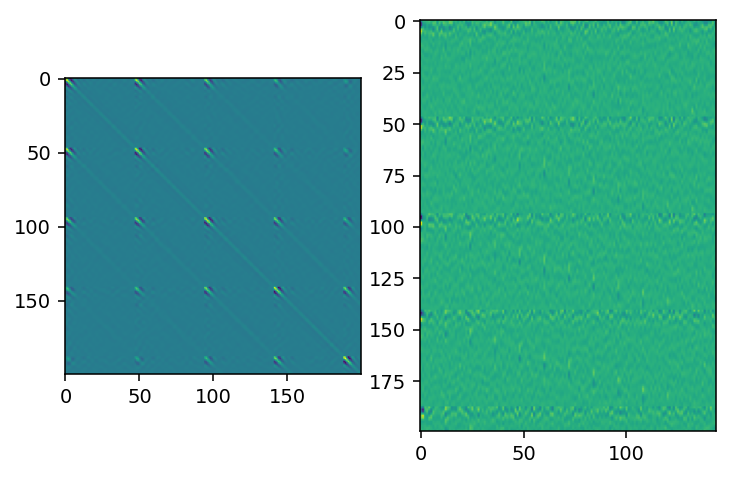

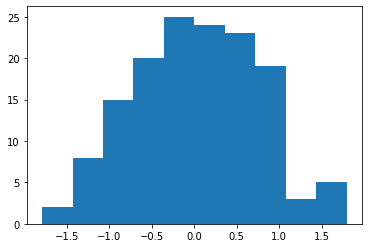

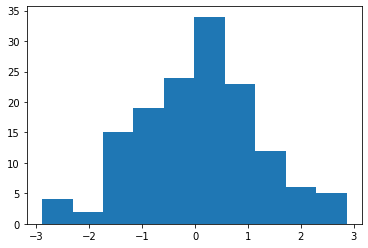

In [ ]:
data_diff = seis - tf.reduce_mean(seis,0)
data_diff = tf.reshape(tf.transpose(seis.numpy().reshape(ensize,n-1,n) - tf.reduce_mean(seis.numpy().reshape(ensize,n-1,n), axis=0), perm=[0,2,1]),[ensize,-1])
model_diff = ms - tf.reduce_mean(ms,0)
#model_diff = tf.reshape(tf.transpose(ms.numpy().reshape(ensize,vae.latent_dim,vae.latent_dim) - tf.reduce_mean(ms.numpy().reshape(ensize,vae.latent_dim,vae.latent_dim), axis=0), perm=[0,2,1]),[ensize,-1])

print(data_diff.shape, model_diff.shape)
C_dd = tf.linalg.matmul(tf.transpose(data_diff), data_diff)/(ensize)
#C_md = tf.linalg.matmul(tf.transpose(model_diff), data_diff)/(ensize)
C_md = tf.linalg.matmul(tf.transpose(data_diff), model_diff)/(ensize)

fig, axs = plt.subplots(1,2,dpi=140)
axs[0].imshow(C_dd[:200,:200])
axs[1].imshow(C_md[:200,:])
plt.show()

K = tf.linalg.matmul(tf.transpose(C_md), tf.linalg.pinv(C_dd + alpha[u]*C_d, 0.001*tf.reduce_mean(tf.linalg.tensor_diag_part(C_d))))

dtio_dp = tf.reshape(d_tio-seis[0], [-1,1])
Ksum = tf.reshape(tf.linalg.matmul(K,dtio_dp), ms[0].shape)

plt.hist(ms[0].numpy().flatten())
plt.show()

plt.hist((ms[0] + Ksum).numpy().flatten())
plt.show()

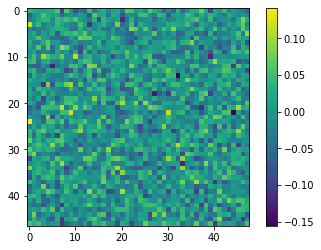

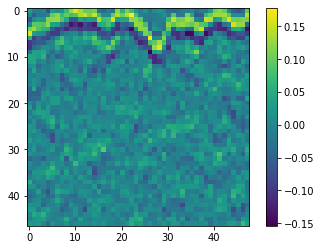

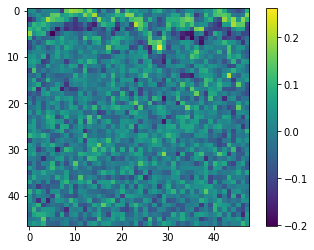

In [ ]:
d_tio = seis_exp + tf.math.sqrt(8.0)*tf.random.normal(seis_exp.shape)*std_noise

fig = plt.figure()
fig.colorbar(plt.imshow((tf.math.sqrt(alpha[u])*tf.random.normal(seis_exp.shape)*std_noise).numpy().reshape(n-1,n)))
plt.show()

fig = plt.figure()
fig.colorbar(plt.imshow(seis_exp.numpy().reshape(n-1,n)))
plt.show()

fig = plt.figure()
fig.colorbar(plt.imshow(d_tio.numpy().reshape(n-1,n)))
plt.show()

In [ ]:
tf.linalg.matmul(tf.transpose(data_diff), model_diff)/(ensize)

<tf.Tensor: shape=(2256, 144), dtype=float32, numpy=
array([[-1.8569421e-02,  2.7537483e-03, -4.8419563e-03, ...,
        -3.1279621e-03,  6.1260234e-03, -2.4969995e-03],
       [-3.8929366e-02, -2.5717721e-03, -9.4919885e-03, ...,
        -6.1083962e-03,  2.5216755e-03,  4.1927051e-04],
       [-3.2433685e-02, -7.7125905e-03, -8.4339585e-03, ...,
        -2.8587461e-03, -3.9156135e-03,  5.8257664e-03],
       ...,
       [ 1.6496870e-03, -4.1815999e-04,  3.2649837e-03, ...,
        -6.5612732e-03,  3.8665268e-03,  1.9758195e-03],
       [ 6.6769921e-04, -9.3716418e-04,  2.1784834e-03, ...,
        -3.9903177e-03,  6.0678209e-04,  4.3054875e-03],
       [-5.0429918e-04, -3.1990869e-05, -6.7262939e-04, ...,
        -1.5239671e-03, -1.6808442e-03,  3.6263200e-03]], dtype=float32)>

In [ ]:
fig = plt.figure()
fig.colorbar(plt.imshow(facies.numpy().reshape(n,n)))
plt.show()